
# MediChal Challenge - Detecting Malaria with cell Images

____

<img src="./logo.jpg" width="200" height="200" align="left"> 

## Team Africa :
- PATAULT Paul
- ESTEVAN Benjamin
- ISKOUNEN Feriel
- NDAO Ndieme
- FERREIRA Jules
- SERRE Gaëtan

<p align="center">
  <img src="example_cells.png">
</p>
<center>Example of parasitized and uninfected cells</center>

Ce notebook regroupe les travaux des trois binômes. La partie 1 est consacrée au preprocessing et la partie 2 au modèle. La visualisation est présente dans les deux parties. Toutes les les fonctions sont appelées et donc testées.

Chargement des données

In [1]:
import sys
model_dir = 'sample_code_submission/'                        # Change the model to a better one once you have one!
result_dir = 'sample_result_submission/' 
problem_dir = 'ingestion_program/'  
score_dir = 'scoring_program/'
from sys import path; path.append(model_dir); path.append(problem_dir); path.append(score_dir); 
%matplotlib inline
# Uncomment the next lines to auto-reload libraries (this causes some problem with pickles in Python 3)
%load_ext autoreload
%autoreload 2
import seaborn as sns; sns.set()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
data_dir = 'malaria_input_data'              # Change this to the directory where you put the input data
data_name = 'malaria'

!ls $data_dir* # Linux command
# !dir $data_dir # Windows command

malaria_feat.name      malaria_test.data      malaria_valid.data
malaria_label.name     malaria_train.data
malaria_public.info    malaria_train.solution


In [3]:
from data_manager import DataManager
from data_io import read_as_df
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#from data_manager import DataManager
D = DataManager(data_name, data_dir, replace_missing=True)
X_valid = D.data['X_valid']
X_test = D.data['X_test']

data = read_as_df(data_dir  + '/' + data_name)                # The data are loaded as a Pandas Data Frame
size = np.array(data.nb_black_pixels).size                    # Numbers of cells in data

nb_p = np.sum(data.target == 'parasitized')
nb_u = np.sum(data.target == 'uninfected')

# There, we make two arrays to separate the parasitized cells from the uninfected ones.
# That way we can detect more precisely which part of the data are outliers.
parasitized = np.zeros((nb_p, 19))
idx_p = 0
uninfected = np.zeros((nb_u, 19))
idx_u = 0
for i in range(size):
    if(data.target[i] == 'parasitized'):
        for j in range(19):
            parasitized[idx_p][j] = data[data.columns[j]][i]
        idx_p = idx_p+1
    if(data.target[i] == 'uninfected'):
        for j in range(19):
            uninfected[idx_u][j] = data[data.columns[j]][i]
        idx_u = idx_u+1

# We decided to use the random forests because of the high-dimensional dataset
clf_p = IsolationForest(n_estimators=10, warm_start=True)
P = clf_p.fit_predict(parasitized,y=None)
nb_inliers = 0
for i in range(nb_p):
    if(P[i] == 1):
        nb_inliers = nb_inliers+1
nb_p = nb_inliers
clf_u = IsolationForest(n_estimators=10, warm_start=True)
U = clf_u.fit_predict(uninfected,y=None)
for i in range(nb_u):
    if(U[i] == 1):
        nb_inliers = nb_inliers+1
nb_u = nb_inliers-nb_p

# After the Random forests have detected all the inliers, 
# we put them in a new array to create a new dataset without outliers.
X = np.zeros((nb_inliers, 19))
target = []
idx = 0
for i in range(P.size):
    if(P[i] == 1):
        X[idx] = parasitized[i]
        target.insert(idx, 'parasitized')
        idx = idx+1
for i in range(U.size):
    if(U[i] == 1):
        X[idx] = uninfected[i]
        target.insert(idx, 'uninfected')
        idx = idx+1
 
d = {data.columns[0]: X[:, 0], data.columns[1]: X[:, 1], data.columns[2]: X[:, 2], 
     data.columns[3]: X[:, 3], data.columns[4]: X[:, 4], data.columns[5]: X[:, 5], 
     data.columns[6]: X[:, 6], data.columns[7]: X[:, 7], data.columns[8]: X[:, 8],
     data.columns[9]: X[:, 9], data.columns[10]: X[:, 10], data.columns[11]: X[:, 11],
     data.columns[12]: X[:, 12], data.columns[13]: X[:, 13], data.columns[14]: X[:, 14],
     data.columns[15]: X[:, 15], data.columns[16]: X[:, 16], data.columns[17]: X[:, 17], 
     data.columns[18]: X[:, 18], data.columns[19]: target[:]}
data = pd.DataFrame(data = d)

# Finally we shuffle the lines of the dataset to not have only one class in smaller arrays like the one of valid data.
data = data.sample(frac=1).reset_index(drop=True)
X_train = D.data['X_train']#data.drop(['target'], axis= 1)
Y_train = D.data['Y_train']#(data.target == 'parasitized')

Info file found : /Users/gaetanserre/Documents/Dev/Cours/L2/Projets/Minis-Projets/Medichal/Africa/starting_kit/malaria_input_data/malaria_public.info
Reading malaria_input_data/malaria_train from AutoML format
Number of examples = 16534
Number of features = 19
         Class
0   uninfected
1  parasitized
Number of classes = 2


## Preprocessing subgroup

Ici nous répondons aux problématiques du sous groupe "preprocessing"

In [5]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
# we use the Tree-based feature selection model to calculate the cross-validation score with only 
# the necessary number of feature
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X_train, Y_train)
feature_selection = SelectFromModel(clf, prefit=True)
X_train = feature_selection.transform(X_train)
print(X_train.shape)
X_test = feature_selection.transform(X_test)
print(X_test.shape)
X_valid = feature_selection.transform(X_valid)
print(X_valid.shape)
features_idx = feature_selection.get_support(indices=True)

(16534, 4)
(5512, 4)
(5512, 4)


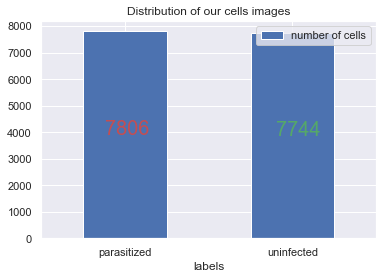

In [6]:
p = pd.DataFrame({'labels':['parasitized', 'uninfected'],'number of cells': [nb_p, nb_u]})
ax = p.plot.bar(x='labels', y='number of cells', rot=0),
plt.text(-0.12, nb_p/2, nb_p , size=20, color='r'),
plt.text(0.9, nb_u/2, nb_u , size=20, color='g'),plt.title('Distribution of our cells images')
plt.show()

In [7]:
data.head()

,nb_black_pixels,var_color,mean_color,min_color,max_color,var_gray,mean_gray,min_gray,max_gray,nb_pixel_0.0_0.1,nb_pixel_0.1_0.2,nb_pixel_0.2_0.3,nb_pixel_0.3_0.4,nb_pixel_0.4_0.5,nb_pixel_0.5_0.6,nb_pixel_0.6_0.7,nb_pixel_0.7_0.8,nb_pixel_0.8_0.9,nb_pixel_0.9_1.0,target
0,6777.0,0.000019,0.983686,0.977072,0.989418,0.094229,0.674079,0.631373,0.752941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6441.0,10780.0,uninfected
1,7173.0,0.000025,0.932207,0.920188,0.943662,0.383149,0.695457,0.286275,0.823529,0.0,0.0,0.0,0.0,11.0,52.0,63.0,195.0,17068.0,1926.0,parasitized
2,4209.0,0.000156,0.972696,0.952218,1.000000,0.108960,0.703714,0.650980,0.768627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2870.0,10211.0,uninfected
3,5646.0,0.000029,0.964605,0.952715,0.978984,0.493495,0.649270,0.192157,0.749020,0.0,0.0,0.0,1.0,33.0,48.0,57.0,183.0,11297.0,3751.0,parasitized
4,7734.0,0.001263,0.909343,0.859862,0.967128,0.973186,0.622954,0.188235,0.760784,0.0,0.0,0.0,4.0,84.0,136.0,288.0,684.0,9147.0,1763.0,parasitized


We have decided to reduce the dataset of images to a simpler dataset with only 19 features.

`nb_black_pixels` counts pixels whose value is dark for gray_scale images, those around the cell in the image.

`var_color` feature is simply the empirical variance of the values of the pixels for colored images.

`mean_color` feature is simply the mean of the values of the pixels for colored images.

`max_color` is the maximum value for colored images.

`min_color` is the maximum value for colored images.

`var_gray`, `mean_gray`, `max_gray` and `min_gray` are the same but for gray-scale images.

`nb_pixel_i_j` is the number of pixels having their value (intensity : 0 = black | 1 = white) between i and j for gray-scale images.

In [8]:
data.describe() 

,nb_black_pixels,var_color,mean_color,min_color,max_color,var_gray,mean_gray,min_gray,max_gray,nb_pixel_0.0_0.1,nb_pixel_0.1_0.2,nb_pixel_0.2_0.3,nb_pixel_0.3_0.4,nb_pixel_0.4_0.5,nb_pixel_0.5_0.6,nb_pixel_0.6_0.7,nb_pixel_0.7_0.8,nb_pixel_0.8_0.9,nb_pixel_0.9_1.0
count,15550.000000,15550.000000,15550.000000,15550.000000,15550.000000,15550.000000,15550.000000,15550.000000,15550.000000,15550.0,15550.000000,15550.000000,15550.000000,15550.000000,15550.000000,15550.000000,15550.000000,15550.000000,15550.000000
mean,5106.917235,0.000152,0.935583,0.919847,0.953049,0.417220,0.643120,0.432267,0.767045,0.0,0.000193,0.003151,0.324887,6.983987,28.106367,122.639614,1545.947524,7400.322958,3492.708939
std,2159.805908,0.000486,0.038465,0.044432,0.035656,0.326206,0.041544,0.166098,0.033798,0.0,0.024058,0.093813,1.857948,17.709896,50.485285,423.721700,2754.469717,3879.699845,3696.879037
min,720.000000,0.000000,0.628472,0.508772,0.628472,0.013198,0.457069,0.066667,0.564706,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000
25%,3771.000000,0.000027,0.915371,0.896610,0.935811,0.162552,0.619235,0.266667,0.745098,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4253.000000,1012.000000
50%,4644.000000,0.000067,0.944229,0.928693,0.961538,0.341093,0.648111,0.450980,0.764706,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,165.000000,7842.000000,2003.000000
75%,5813.250000,0.000150,0.963756,0.951907,0.978689,0.577651,0.672554,0.592157,0.788235,0.0,0.000000,0.000000,0.000000,2.000000,46.000000,97.000000,1421.000000,10287.000000,4470.000000
max,31935.000000,0.030410,1.000000,1.000000,1.000000,3.433721,0.748599,0.705882,0.913725,0.0,3.000000,6.000000,44.000000,393.000000,971.000000,8159.000000,17071.000000,23596.000000,23478.000000


Histogram of our features:

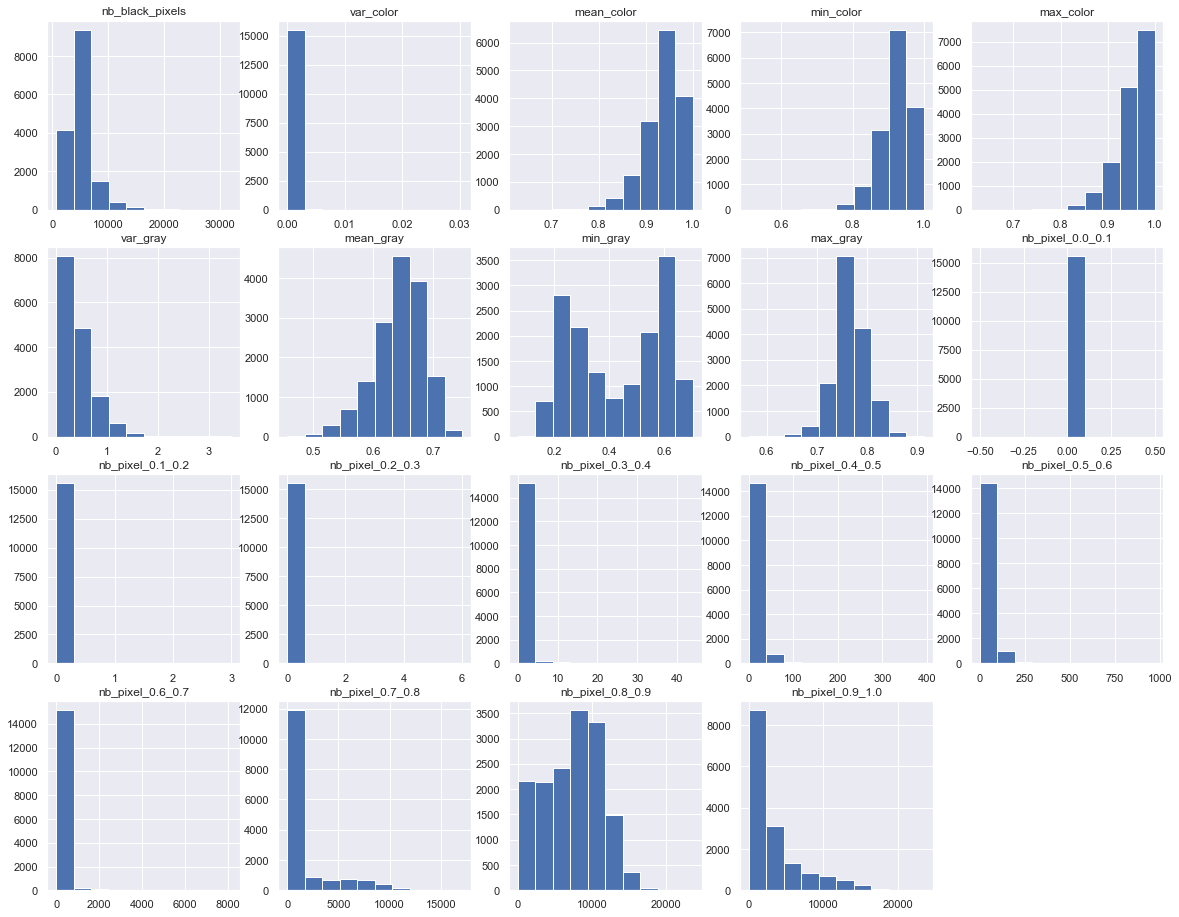

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,16))

for t in range(19):
    plt.subplot(4,5,t+1)
    plt.hist(data[data.columns[t]])
    plt.title(data.columns[t])
    t+=1

Let's try to indentify patterns with a pairplot, which will maybe give us structures for each class depending on 2 features.

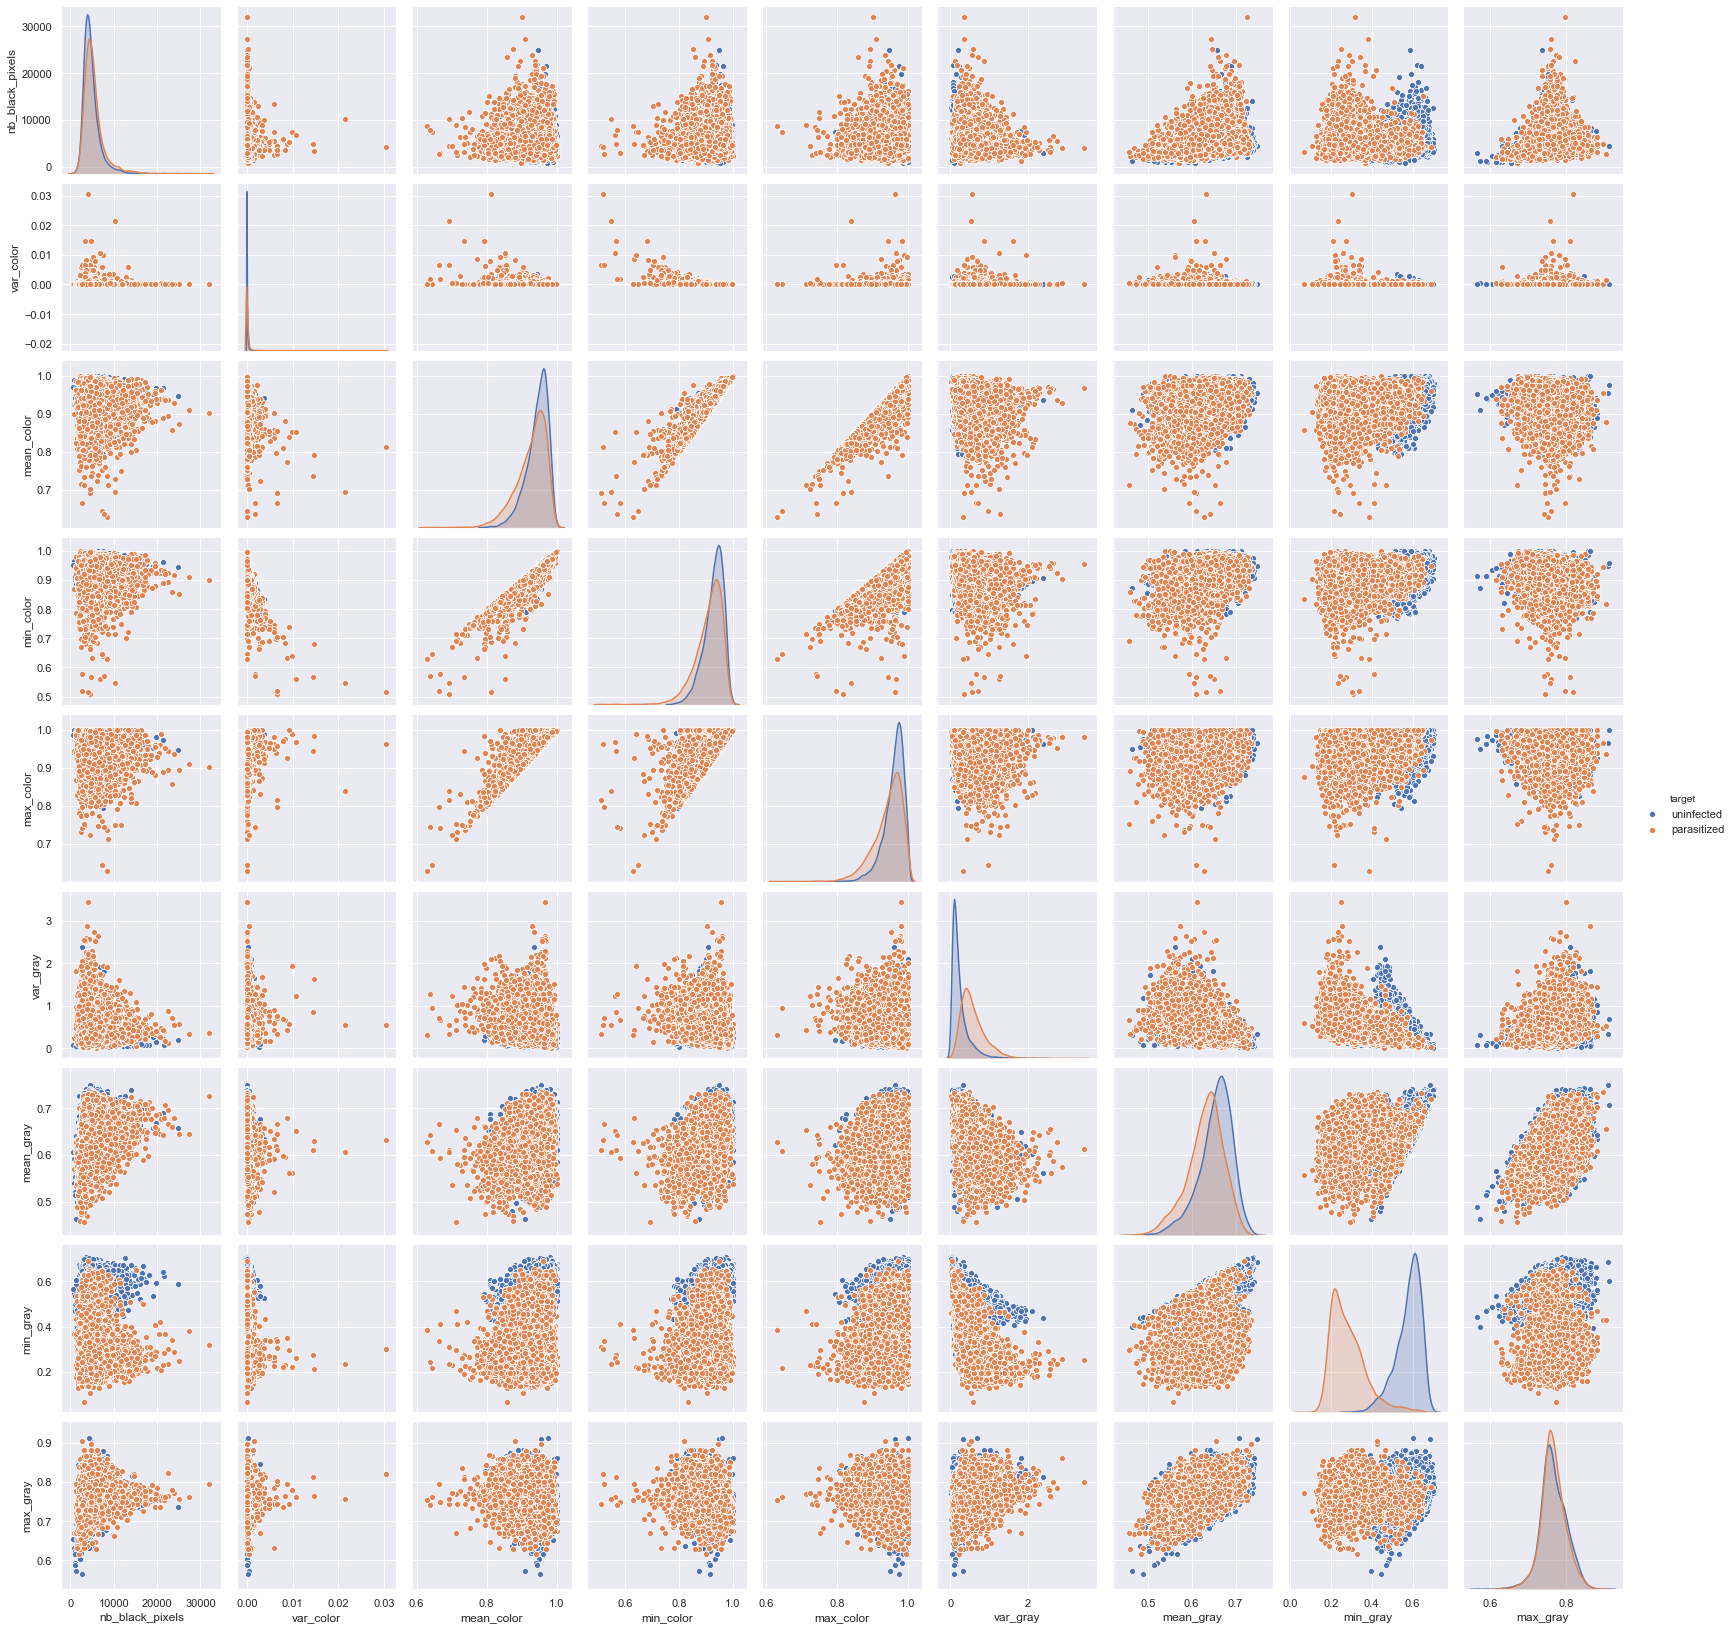

In [10]:
sns.pairplot(data[['target','nb_black_pixels','var_color','mean_color','min_color','max_color','var_gray','mean_gray','min_gray','max_gray']], hue="target")

Correlation of our features with the target: 'parasitized'

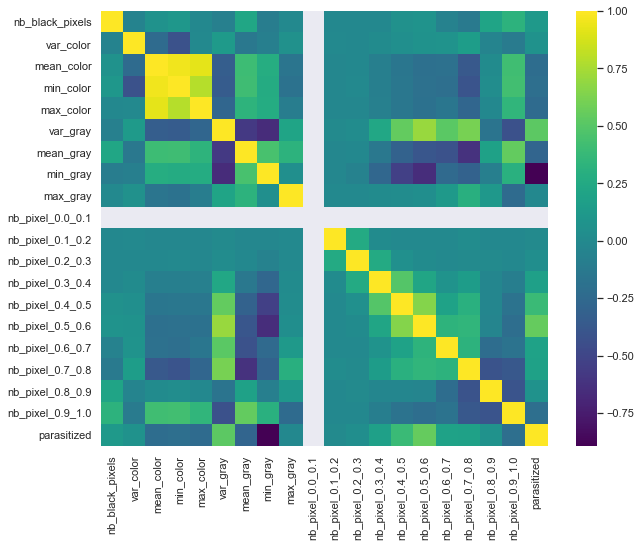

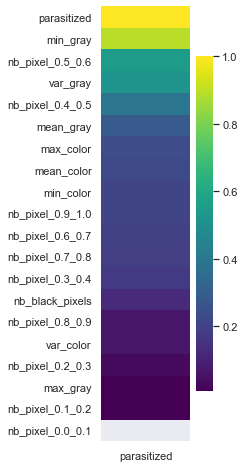

In [11]:
datatarget = pd.get_dummies(data['target'])['parasitized'].to_frame()
new_df = pd.merge(data, datatarget, right_index=True, left_index=True)
df_new = new_df.select_dtypes(include=np.number)

plt.figure(figsize = (10, 8))
ax = sns.heatmap(df_new.corr(),cmap="viridis", xticklabels=True, yticklabels=True)

d=pd.get_dummies(data['target'])['parasitized']

n_df = pd.merge(d.to_frame(), data, right_index=True, left_index=True)
df_n = n_df.select_dtypes(include=np.number).abs()


plt.figure(figsize = (2, 8))
ax = sns.heatmap(df_n.corr().abs().sort_values(['parasitized'], ascending=[0])["parasitized"].to_frame(), cmap="viridis", xticklabels=True, yticklabels=True)

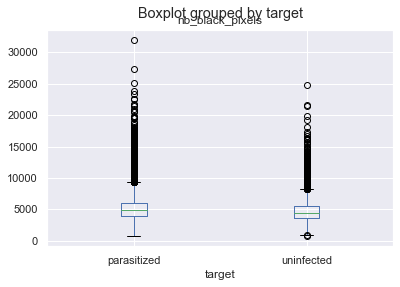

In [12]:
boxplot = data.boxplot(column=['nb_black_pixels'], by='target', )

There seem to have no correlation between the number of black pixels and the target as well, then there is no dataleakage.

From the correlation matrix, the feature that has the highest correlation with the target is "min_gray".

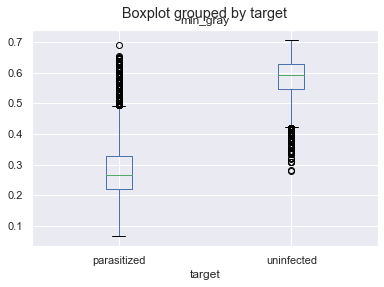

In [13]:
boxplot = data.boxplot(column=['min_gray'], by='target', )

## Model subgroup

Ici nous répondons aux problématiques du sous groupe "model"

<h3>T-SNE visualization</h3>

In [14]:
from sklearn.manifold import TSNE
hue = []
hue3D = []
for i in Y_train:
    if i :
        hue.append('parasitized')
        hue3D.append((0,0,1,0.5))
    else:
        hue.append('uninfected')
        hue3D.append((1,0.65,0,0.5))
        
model2D = TSNE(n_components=2, verbose=True)
model3D = TSNE(n_components=3, verbose=True)
tsne_results2D = model2D.fit_transform(X_train)
tsne_results3D = model3D.fit_transform(X_train)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 16534 samples in 0.088s...
[t-SNE] Computed neighbors for 16534 samples in 0.562s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16534
[t-SNE] Computed conditional probabilities for sample 2000 / 16534
[t-SNE] Computed conditional probabilities for sample 3000 / 16534
[t-SNE] Computed conditional probabilities for sample 4000 / 16534
[t-SNE] Computed conditional probabilities for sample 5000 / 16534
[t-SNE] Computed conditional probabilities for sample 6000 / 16534
[t-SNE] Computed conditional probabilities for sample 7000 / 16534
[t-SNE] Computed conditional probabilities for sample 8000 / 16534
[t-SNE] Computed conditional probabilities for sample 9000 / 16534
[t-SNE] Computed conditional probabilities for sample 10000 / 16534
[t-SNE] Computed conditional probabilities for sample 11000 / 16534
[t-SNE] Computed conditional probabilities for sample 12000 / 16534
[t-SNE] Computed conditional probabilities for sam

Affichage T-SNE 2D

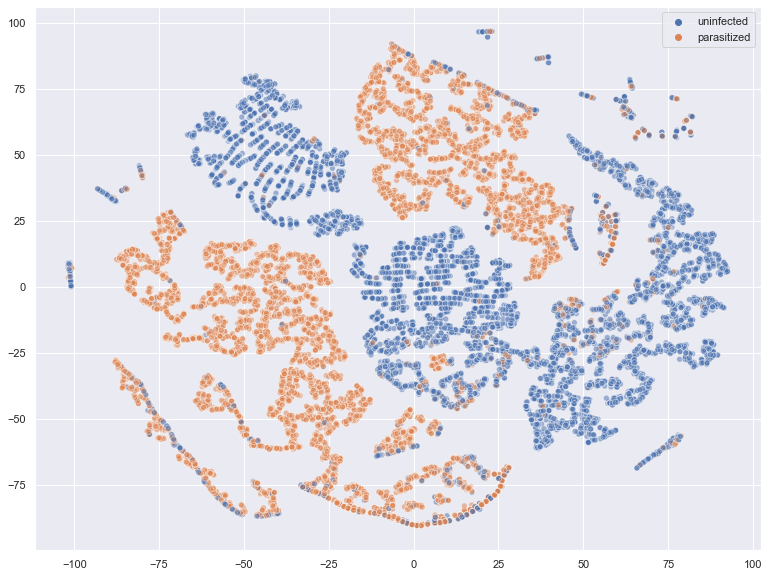

In [15]:
plt.figure(figsize=(13,10))
sns.scatterplot(x=tsne_results2D[:,0], y=tsne_results2D[:,1], hue=hue,legend="full",
    alpha=0.5)

Affiche T-SNE 3D

In [14]:
from mpl_toolkits.mplot3d import axes3d
%matplotlib notebook
ax = plt.figure(figsize=(13,10)).gca(projection='3d')
ax.scatter(
    xs=tsne_results3D[:,0], 
    ys=tsne_results3D[:,1], 
    zs=tsne_results3D[:,2], 
    c=hue3D, 
    cmap='tab10'
)

<IPython.core.display.Javascript object>

NameError: name 'tsne_results3D' is not defined

In [17]:
%matplotlib inline

On teste ici 5 classifiers différents et on stocke les prédictions et les matrices de confusion dans des listes

In [6]:
# Création d'une classe regroupant les fonctions utiles d'un classifier
from libscores import get_metric
from sklearn.metrics import confusion_matrix
metric_name, scoring_function = get_metric()

class modelGest():
    def __init__(self, model_, name, X_train, y_train, X_test, y_test): 
        self.model = model_
        self.name = name
        self.X_train = X_train 
        self.y_train = y_train 
        self.X_test = X_test 
        self.y_test = y_test
        self.result = None
    

    def train(self): 
        self.model.fit(self.X_train, self.y_train)

    
    def predict(self): 
        self.result = self.model.predict(self.X_test)
        

    def printConfusionMatrix(self): 
        matrice = confusion_matrix(self.y_test, self.result)
        
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(6, 6))

        sns.heatmap(matrice, annot=True, fmt='g', ax=ax); #annot=True to annotate cells
        # labels, title and ticks
        ax.set_xlabel('Predicted labels');
        ax.set_ylabel('True labels'); 
        ax.set_title(self.name); 
        ax.xaxis.set_ticklabels(['Parasitized', 'Uninfected']);
        ax.yaxis.set_ticklabels(['Parasitized', 'Uninfected']);

        plt.show()


    def getScore(self): 
        return scoring_function(self.y_test, self.result)

In [7]:
from sklearn.model_selection import train_test_split
from model import model
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier

Xs_train = []
Xs_test = []
ys_train = []
ys_test = []
for i in range(0, 20):
    X_train_pre, X_test_pre, y_train_pre, y_test_pre = train_test_split(X_train, Y_train, test_size=0.33)
    Xs_train.append(X_train_pre)
    Xs_test.append(X_test_pre)
    ys_train.append(y_train_pre)
    ys_test.append(y_test_pre)

# Load model
# tableau des 5 modèles choisis
classifiers_type = [
    RandomForestClassifier(),
    MLPClassifier(solver='lbfgs'),
    SGDClassifier(),
    GaussianNB(),
    KNeighborsClassifier()
]

name_classifiers = [
    'RandomForestClassifier',
    'MLPClassifier',
    'SGDClassifier',
    'GaussianNB',
    'KNeighborsClassifier'
]


models = []
for i in range (0, len(Xs_train)):
    temp = []
    for cls, name in zip(classifiers_type, name_classifiers):
        m = modelGest(cls, name, Xs_train[i], ys_train[i], Xs_test[i], ys_test[i])
        m.train()
        m.predict()
        temp.append(m)
    models.append(temp)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_mult

On affiche les matrices de confusion des classifiers

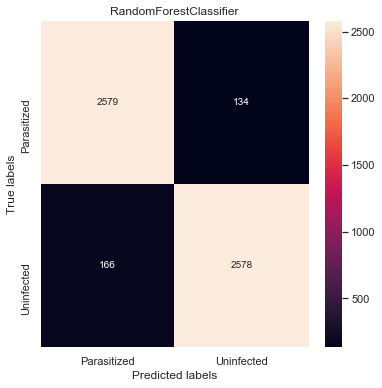

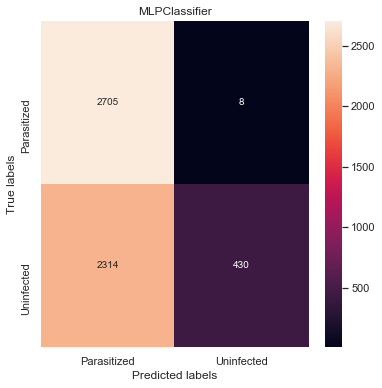

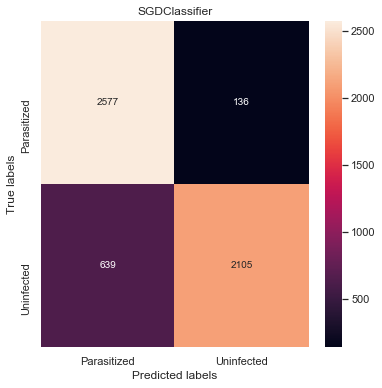

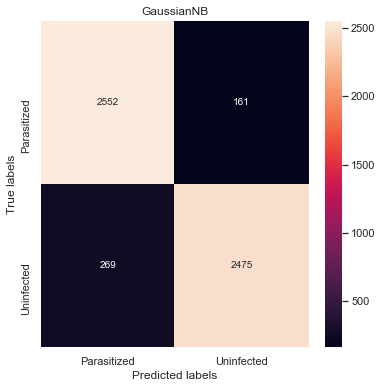

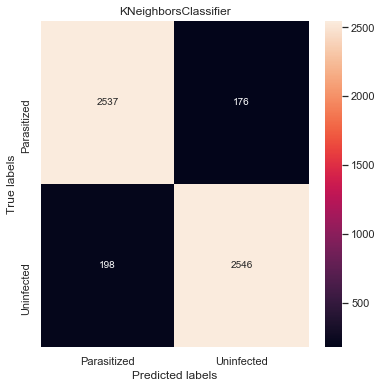

In [20]:
count = 1
for mod in models[0]:
    mod.printConfusionMatrix()
    count+=1

On affiche les scores des classifiers

In [21]:
for i in range(0, len(models[0])):
    scores = []
    name = models[0][i].name
    for j in range(0, len(models)):
        scores.append(models[j][i].getScore())
    print('Score for', name, ":" , str(round(100*np.mean(scores),4)) + '%', '±', str(round(100*np.var(scores),4)) + '%')

Score for RandomForestClassifier : 94.4124% ± 0.0007%
Score for MLPClassifier : 62.8524% ± 4.6869%
Score for SGDClassifier : 89.3226% ± 0.1192%
Score for GaussianNB : 91.8413% ± 0.0015%
Score for KNeighborsClassifier : 92.9718% ± 0.0006%


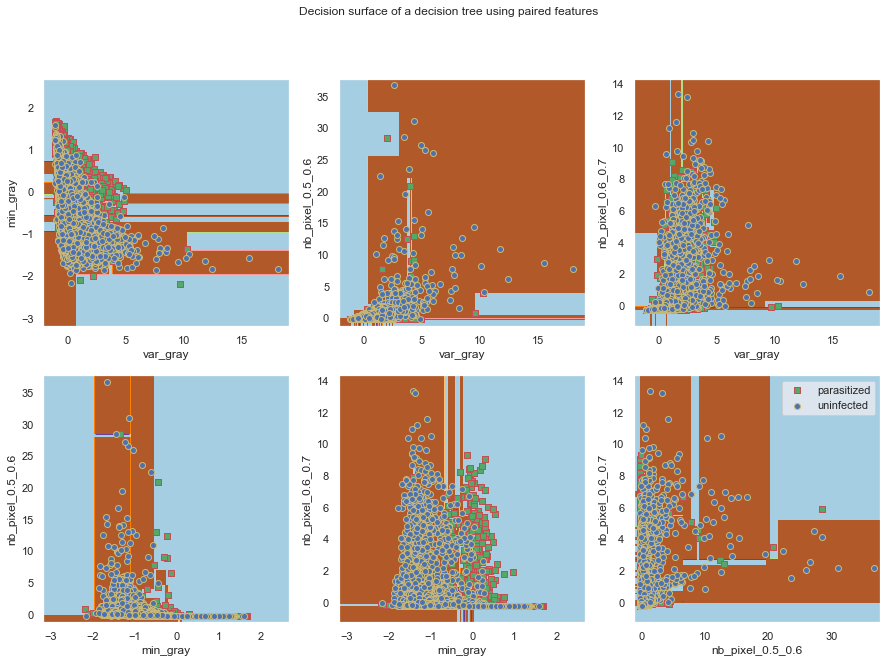

In [22]:
from sklearn.tree import DecisionTreeClassifier

# Parameters
n_classes = 2
plot_colors = ['g','b']
plot_edgecolors = ['r','y']
plot_markers = ['s','o']
plot_classes = ['parasitized', 'uninfected']
plot_step = 0.02
features_array = data.columns.values
plt.figure(figsize=(15,10))
liste = []
for i in range(0, len(X_train[0])-1):
    for j in range(i+1, len(X_train[0])):
        temp = [i]
        temp.append(j)
        liste.append(temp)

for pairidx, pair in enumerate(liste):
    # We only take the two corresponding features
    X = X_train[:,pair] #iris.data[:,pair]
    y = Y_train #iris.target
    

    # Shuffle
    idx = np.arange(X.shape[0])
    np.random.seed(13)
    np.random.shuffle(idx)
    X = X[idx]
    y = y[idx]

    # Standardize
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    X = (X - mean) / std
    
    # Train
    clf = DecisionTreeClassifier().fit(X, y)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    plt.xlabel(features_array[features_idx[pair[0]]])
    plt.ylabel(features_array[features_idx[pair[1]]])
    plt.axis("tight")

    # Plot the training points
    for i, color, edge_color, marker, classe in zip(range(n_classes), plot_colors, plot_edgecolors, plot_markers, plot_classes):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, edgecolor=edge_color, marker=marker, label=classe,
                    cmap=plt.cm.Paired)

    plt.axis("tight")

plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend()
plt.show()

<div>
Nous avons pu remarquer que le modèle des Random Forest possédait le meilleur score des 5 modèles testés.
Le paramètre le plus important est n_estimator correspondant au nombre d'arbres de décision dans notre Random Forest.
Plus ce nombre est important, plus la prédiction sera meilleure, jusqu'à un certain stade à cause du sur-apprentissage.
max_depth et max_features correspondent respectivement à la profondeur maximum d'un arbre et le nombre de features
à tester sur chaque arbre. En mettant ces deux paramètres à None, cela permet de tester chaque feature sur chaque arbre, permettant de meilleur résultats en contrepartie d'un temps de calcul plus long.
</div>

On cherche les meilleurs hyper-paramètres d'une RandomForest avec RandomizedSearchCV

In [23]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['sqrt', 'auto', None]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(),
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2, 
                               random_state=None, 
                               n_jobs = -1)

In [24]:
# /!\ ~40 MIN DE CHARGEMENT
''' entrainement des modèles générés par RandomizedSearchCV'''
rf_random.fit(X_train, Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 39.5min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

On affiche les meileurs hyper-paramètres

In [25]:
for key,value in rf_random.best_params_.items():
    print(key, ':', value)

n_estimators : 200
min_samples_split : 10
min_samples_leaf : 2
max_features : sqrt
max_depth : None
bootstrap : True


On compare le score d'une RandomForest avec les hyper-paramètres de base avec celui d'une RandomForest avec les meilleurs hyper-paramètres trouvés par  RandomizedSearchCV

In [26]:
base_example_model = RandomForestClassifier()
base_example_model.fit(X_train, Y_train)
score_base_clf = 100*scoring_function(ys_test[0], base_example_model.predict(Xs_test[0]))
print("Score modèle de base : {:0.4f}%".format(score_base_clf))

best_random = rf_random.best_estimator_
score_random_clf = 100*scoring_function(ys_test[0], best_random.predict(Xs_test[0]))
print("Score meilleur modèle de RandomizedSearchCV : {:0.4f}%".format(score_random_clf))

print("Amélioration de {:0.4f}%".format(100 * (score_random_clf - score_base_clf) / score_base_clf))

Score modèle de base : 100.0000%
Score meilleur modèle de RandomizedSearchCV : 96.6706%
Amélioration de -3.3294%


On exporte nos résultats

In [11]:
from data_io import write
from data_io import zipdir
import datetime
from sklearn.ensemble import RandomForestClassifier
from libscores import get_metric
from model import model

result_name = result_dir + data_name
model = model(RandomForestClassifier())
model.fit(X_train, Y_train)
write(result_name + '_train.predict', model.predict(X_train))
write(result_name + '_valid.predict', model.predict(X_valid))
write(result_name + '_test.predict', model.predict(X_test))

the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
sample_result_submission = '../sample_result_submission_' + the_date + '.zip'
zipdir(sample_result_submission, result_dir)

FIT: dim(X)= [16534, 4]
FIT: dim(y)= [16534, 1]
PREDICT: dim(X)= [16534, 4]
PREDICT: dim(y)= [16534, 1]
PREDICT: dim(X)= [5512, 4]
PREDICT: dim(y)= [5512, 1]
PREDICT: dim(X)= [5512, 4]
PREDICT: dim(y)= [5512, 1]
